# LBHB: low barrier hydrogen bonds




## Libraries and setup  

In [75]:
import math
import pandas as pd
import sys
import numpy as np

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.width',None)
pd.set_option('display.max_colwidth',None)

## Data folder and PDB accessions

In [76]:
srt_i =0#srt_i=int(sys.argv[1])
stp_i = 999999 #stp_i=int(sys.argv[2])
data_dir = "../data"
with open("../data/pdb_list.txt", encoding="utf-8") as f:
    read_data = f.read()
    pdb_list = read_data.split('\n')

print("number of pdbs = %s"%len(pdb_list))

if stp_i < len(pdb_list):
    pdb_list = pdb_list[srt_i:stp_i]
else:
    pdb_list = pdb_list[srt_i:]
    stp_i=len(pdb_list)
print("number of pdbs = %s"%len(pdb_list))
print(pdb_list[:10])

number of pdbs = 22268
number of pdbs = 22268
['121p_A', '13pk_A', '13pk_B', '13pk_C', '13pk_D', '1a0c_A', '1a0c_B', '1a0c_C', '1a0c_D', '1a0d_A']


## Default parameters radii and metals

In [77]:
MAX_LBHB_DIST = 6.5
METAL_RES_CODES= [ "FE" ,"FE2","FES","FEO"
                 ,"CU" ,"CU1","CUA"
                 ,"MG" ,"ZN" ,"MN"
                 ,"MO" ,"MOO","MOS"
                 ,"NI" ,"3CO","CO"]

# Parse PDB files in data folder

## Function 1: split_ATOM


**split_ATOM()** takes a PDB ATOM record as input and returns a tuple containing the following information:

- serial number (6-11 characters)
- Atom name (11-16 characters)
- Residue name (16th character)
- Residue sequence number (17-20 characters)
- X-coordinate (21-26 characters)
- Y-coordinate (27-30 characters)
- Z-coordinate (31-36 characters)
- Occupancy (37-41 characters)
- Temperature factor (42-46 characters)
- Element symbol (46-53 characters)
- Charge (54-59 characters)
- Radius (60-65 characters)
- Segment identifier (72-75 characters)
- TER flag (76-78 characters)
- Unknown field (79-80 characters)

This function allows to extract the values in PDB files. The function works by splitting the ATOM record into 14 columns, each containing a single piece of information. The function then removes all whitespace from each column and returns the tuple of columns.

In [78]:
def split_ATOM(raw):
    return(raw.str[6:11].str.replace(' ', ''),  
           raw.str[11:16].str.replace(' ', ''),
           raw.str[16].str.replace(' ', ''),
           raw.str[17:20].str.replace(' ', ''), 
           raw.str[21].str.replace(' ', ''),
           raw.str[22:26].str.replace(' ', ''),
           raw.str[27].str.replace(' ', ''),
           raw.str[30:37].str.replace(' ', ''),
           raw.str[38:45].str.replace(' ', ''),
           raw.str[46:53].str.replace(' ', ''),
           raw.str[54:59].str.replace(' ', ''),
           raw.str[60:65].str.replace(' ', ''),
           raw.str[72:75].str.replace(' ', ''),
           raw.str[76:78].str.replace(' ', ''),
           raw.str[79:].str.replace(' ', ''))
    


## Function 2: get_ATOM_DF

'ATOM' and 'HETATM' use get_ATOM_DF for a atom level dataframe


In [79]:
def get_ATOM_DF(ATOM, pdb=None):
    atom_data = split_ATOM(ATOM['raw'])
    ATOM = pd.DataFrame({
         'serial':atom_data[0],
         'atom_name':atom_data[1],
         'altLoc':atom_data[2],
         'resName':atom_data[3],
         'chainID':atom_data[4],
         'seqNum':atom_data[5],
         'iCode':atom_data[6],
         'x':atom_data[7],
         'y':atom_data[8],
         'z':atom_data[9],
         'occupancy':atom_data[10],
         'tempFactor':atom_data[11],
         'segID':atom_data[12],
         'element':atom_data[13],
         'charge':atom_data[14] })
    # change coordinates to float to make them usable
    ATOM['x']=ATOM['x'].astype(float)
    ATOM['y']=ATOM['y'].astype(float)
    ATOM['z']=ATOM['z'].astype(float)
    return(ATOM)

## Function3: get_struc_atom_coords

**get_struc_atom_coords()** takes the full path to a PDB file as input and returns a DataFrame containing the atomic coordinates for all atoms in the structure.

The function works as follows:

- It opens the PDB file and reads all of the lines into a list.
- It then creates a pandas DataFrame from the list of lines, with each line representing a single record in the PDB file.
- It uses the str[:80] slice operator to extract the first 80 characters from each record. This is because the first 80 characters of a PDB record contain all of the information necessary to extract the atomic coordinates.
- It then uses the str[:6].str.replace(' ', '') slice operator and string replacement function to extract the type of record from each record. - This is necessary to distinguish between ATOM and HETATM records.
- It then uses the pdb_file_df[pdb_file_df['key'] == 'ATOM'] filter to select all of the ATOM records from the DataFrame.
- It then calls the get_ATOM_DF() function to extract the atomic coordinates from the ATOM records.
- If there are any HETATM records in the PDB file, the function calls the get_ATOM_DF() function to extract the atomic coordinates from those records as well.
- Finally, the function concatenates the atomic coordinates from the ATOM and HETATM records into a single DataFrame and returns the DataFrame.

The get_ATOM_DF() function is a helper function that extracts the atomic coordinates from a single ATOM or HETATM record. The function works by splitting the record into 14 columns, each containing a single piece of information. The function then extracts the X, Y, and Z coordinates from the 14 columns and returns them as a NumPy array.

In [80]:
def get_struc_atom_coords(fullpath2pdbfile):
    f = open(fullpath2pdbfile, "r")
    pdb_lines = f.readlines()
    pdb_file_df = pd.DataFrame(pdb_lines, columns = ['raw'])
    pdb_file_df['raw'] = pdb_file_df['raw'].str[:80]
    pdb_file_df['key'] = pdb_file_df['raw'].str[:6].str.replace(' ', '')
    ## only keep first model, mostly for NMR models
    atom_coords = get_ATOM_DF(pdb_file_df[pdb_file_df['key'] == 'ATOM'])
    if len(pdb_file_df[pdb_file_df['key'] == 'HETATM'])>0:
        hetatm_coords = get_ATOM_DF(pdb_file_df[pdb_file_df['key'] == 'HETATM'])
        atom_coords = pd.concat([atom_coords, hetatm_coords], ignore_index=True)
    #atom_coords.reset_index(drop=True, inplace=True)
    return(atom_coords)


# bluues pKa


## Parameters

In [81]:
POTENTIAL_IONIZE_RES_ATOMS = [
    'LYS_NZ', 'LYS_N', 'LYS_O',
    'ARG_NH1', 'ARG_NH2', 'ARG_NE', 'ARG_N', 'ARG_O',
    'HIS_NE2', 'HIS_ND1', 'HIS_N', 'HIS_O',
    'ASP_OD1', 'ASP_OD2', 'ASP_N', 'ASP_O',
    'GLU_OE1', 'GLU_OE2', 'GLU_N', 'GLU_O',
    'TYR_OH', 'TYR_N', 'TYR_O',
    'MET_SD', 'MET_N', 'MET_O', 
    'SER_OG', 'SER_N', 'SER_O',
    'THR_OG1', 'THR_N', 'THER_O',
    'CYS_SG', 'CYS_N', 'CYS_O',
    'ASN_ND2', 'ASN_OD1', 'ASN_N', 'ASN_O',
    'GLN_NE2', 'GLN_OE1', 'GLN_N', 'GLN_O']

## Function 4: get_resi_pKas
Read a CSV file containing pka_values 

In [82]:
pka_file_cols = ["atom_name", "resName", "seqNum", "predicted_pKa",  "reference_pKa", 
                 "pKa_shift_desolvation_self-energy", "pKa_shift_background_interactions", 
                 "pKa_shift_charge-charge_interactions", "generalized_Born_radius", 
                 "solvent_exposure_parameter"]

In [83]:
def get_resi_pKas(pka_file):
    pka_data = pd.read_csv(pka_file, sep='\s+', names=pka_file_cols, skiprows=1)
    pka_data = pka_data.loc[~pka_data['atom_name'].isin(["N", "C"])]
    return(pka_data)

## Function 5: get_pka_coords_data

In [84]:
def get_pka_coords_data(this_pka_data, this_atom_coords, this_struc_id):
     for this_df in [this_pka_data, this_atom_coords]:
          this_df["atom_name"]=this_df["atom_name"].astype(str).str[:]
          this_df["resName"]=this_df["resName"].astype(str)
          this_df["seqNum"]=this_df["seqNum"].astype(int)

     del this_pka_data['atom_name']
     this_pka_coords_data = pd.merge(this_pka_data, this_atom_coords, 
                                     left_on=["resName", "seqNum"], 
                                     right_on=["resName", "seqNum"] )
     
     ## only keep atoms that could form a sidechain LBHB
     this_pka_coords_data['res_atom'] = (
          this_pka_coords_data['resName']+"_"+this_pka_coords_data['atom_name'])
     this_pka_coords_data = this_pka_coords_data.loc[
          this_pka_coords_data['res_atom'].isin(POTENTIAL_IONIZE_RES_ATOMS)]
     this_pka_coords_data.reset_index(drop=True, inplace=True)
     return(this_pka_coords_data)

# LHBH - low barrier hydrogen bonds

## Function 6: get_LBHB_pairs

In [85]:
# Obtain solvation energy values for each atom
def solvnrg(slvnrg_file):
     with open(slvnrg_file, 'r') as f:
          data = f.read()
     lines = data.split('\n')
     df = pd.DataFrame([line.split() for line in lines if line.startswith('SOLV')],
                    columns=['c1', 'c2', 'c3', 'atom', 'res', 'resn', 'charge', 'solv_nrg'])
     df['atom_code'] = df['res'] + df['resn'] + '_' + df['atom']
     df['charge'] = df['charge'].astype(float)
     return df[['atom_code', 'charge']]
solvnrg_path = '../data/7/a/7adh_A/7adh_A_bluues.solv_nrg'
print(solvnrg(solvnrg_path).shape, solvnrg(solvnrg_path)[:2])

# assign a tier related to the distance to Metal-ion 
def metal_tier(mdistance):
    mdist = float(mdistance)
    tier = '10-15' if mdist >10 else ('5-10' if mdist > 5 else '0-5')
    return tier 


(5637, 2)   atom_code  charge
0    SER1_N   -0.32
1   SER1_CA    0.33


In [86]:
def get_LBHB_pairs(this_data_dir, this_struc_id, lbhb_maxdist, metal_maxdist):
    print(this_struc_id)
    this_struc_file = "%s/%s_Rlx.pdb"%(this_data_dir, this_struc_id)
    slvnrg_file = "%s/%s_bluues.solv_nrg"%(this_data_dir, this_struc_id)

    # data from pdb and from solvation_energy
    df_pdb = get_struc_atom_coords(this_struc_file)
    df_pdb['atom_code'] = df_pdb['resName'] + df_pdb['seqNum'] + '_' + df_pdb['atom_name']
    df_slvnrg = solvnrg(slvnrg_file)
    #merge solvation energy values
    df_pdb = df_pdb.merge(df_slvnrg.set_index('atom_code'), how='left', on='atom_code', suffixes=('', '_y'))
    df_pdb = df_pdb.drop('charge', axis=1)
    df_pdb = df_pdb.rename(columns={'charge_y': 'charge'})
    #Select only the atoms participating in HB 
    NandO_df = df_pdb.loc[df_pdb['element'].isin(['N','O', 'S'])].copy()
    for col in ["atom_name", "resName", "seqNum", "x", "y", "z", 'charge']:
        NandO_df.rename(columns={col:"%s2"%col}, inplace=True)
    ## generate atom pairs
    combinations = []
    temp_df = NandO_df[["atom_name2", "resName2", "seqNum2", "x2", "y2", "z2", "charge2"]]
    temp_df['res_id'] = temp_df["resName2"].astype(str) + temp_df["seqNum2"].astype(str)
    
    new_colnames = ["atom2", "residue2", "resNum2", "x2", "y2", "z2", 'charge2', 'res_id2',\
                    "atom1", "residue1", "resNum1", "x1", "y1", "z1", 'charge1', 'res_id1']
    
    for row1 in temp_df.itertuples():
        for row2 in temp_df.itertuples():
            if row1[8] == row2[8]: #evaluates if residues are the same
                continue
            new_row = row1[1:] + row2[1:]
            combinations.append(new_row)
    atom_pairs = pd.DataFrame(combinations, columns=new_colnames)
    atom_pairs["da_atom2"] = np.where(atom_pairs["charge2"].astype(float) < atom_pairs["charge1"].astype(float), "a", "d")
    atom_pairs["da_atom1"] = np.where(atom_pairs["da_atom2"] == 'a', "d", "a")

    # Caluclate distance between atom pairs 
    atom_pairs = atom_pairs[atom_pairs['res_id2'] != atom_pairs['res_id1']]
    sq_difx = (atom_pairs['x1']-atom_pairs['x2'])**2
    sq_dify = (atom_pairs['y1']-atom_pairs['y2'])**2
    sq_difz = (atom_pairs['z1']-atom_pairs['z2'])**2
    atom_pairs['distance']= (sq_difx + sq_dify + sq_difz).apply(math.sqrt)

    ## bond type  
    atom_pairs['bond_id'] = (atom_pairs["residue1"].astype(str) + "_" + atom_pairs["resNum1"].astype(str) + "_" +
                             atom_pairs["residue2"].astype(str) + "_" + atom_pairs["resNum2"].astype(str))
    
    atom_pairs.loc[atom_pairs["resNum1"]>atom_pairs["resNum2"],'bond_id'] = (
        atom_pairs["residue2"].astype(str) + "_" + atom_pairs["resNum2"].astype(str) + "_" +
        atom_pairs["residue1"].astype(str) + "_" + atom_pairs["resNum1"].astype(str))
    
    # Filter for the shortest
    atom_pairs.sort_values("distance", ascending=True, inplace=True)
    atom_pairs.drop_duplicates(subset=['bond_id'], keep='first', inplace=True, ignore_index=False)
    LBHB_data = atom_pairs.loc[atom_pairs['distance']<= lbhb_maxdist].copy().reset_index(drop=True)


    LBHB_data.loc[LBHB_data['atom1'].isin(['N','O']), 'bond_id'] += '_bb'
    LBHB_data.loc[~LBHB_data['atom1'].isin(['N','O']), 'bond_id'] += '_sc'
    LBHB_data.loc[LBHB_data['atom2'].isin(['N','O']), 'bond_id'] += '_bb'
    LBHB_data.loc[~LBHB_data['atom2'].isin(['N','O']), 'bond_id'] += '_sc'

    for coord_axis in ['x', 'y', 'z']:
        LBHB_data[coord_axis]=LBHB_data["%s1"%(coord_axis)]+LBHB_data["%s2"%(coord_axis)]
        LBHB_data[coord_axis]=LBHB_data[coord_axis]/2

    LBHB_data['metal_name'] = ""
    LBHB_data['metal_num'] = 0
    LBHB_data['metal_dist'] = 10000

    metals = df_pdb.loc[df_pdb["resName"].isin(METAL_RES_CODES)]
    if len(metals)>0:
        for index, row in LBHB_data.iterrows():
            cur_metals = metals.copy()
            cur_metals['distance']=((cur_metals['x'].astype(float)-row['x'])**2 + (cur_metals['y'].astype(float)-row['y'])**2 + \
                                    ((cur_metals['z'].astype(float)-row['z'])**2)).apply(math.sqrt)
            min_dist = cur_metals['distance'].min()
            LBHB_data.loc[index, 'metal_dist'] = min_dist
            LBHB_data.loc[index, 'metal_name']= cur_metals.loc[cur_metals['distance']==min_dist, 'resName'].tolist()[0]
            LBHB_data.loc[index, 'metal_num']= cur_metals.loc[cur_metals['distance']==min_dist, 'seqNum'].tolist()[0]
            LBHB_df = LBHB_data.loc[LBHB_data['metal_dist'] <= metal_maxdist].copy().reset_index(drop=True)

    LBHB_df['hb_type'] = LBHB_df['bond_id'].str[-5:]
    LBHB_df['charge_diff'] = LBHB_df['charge2'] - LBHB_df['charge1']
    LBHB_df.loc[LBHB_df["hb_type"] == "sc_bb", "hb_type"] = "bb_sc"
    # Final output data
    LBHB_df = LBHB_df[["atom2", "atom1", "x2", "y2", "z2", "x1", "y1", "z1", "residue2", "residue1","resNum2", "resNum1",
                       'da_atom2', 'distance', 'charge_diff', 'metal_name', 'metal_dist', 'hb_type']]
    print(this_struc_id, LBHB_df.shape)
    return(LBHB_df)

In [87]:
this_data_dir = '../data/7/a/7adh_A'
this_struc_id = '7adh_A'
lb_7adh = get_LBHB_pairs(this_data_dir, this_struc_id, 4.5, 15)
lb_7adh.to_csv("../results/hb_7adh.csv")
len(lb_7adh)
lb_7adh[:5]

7adh_A


/var/folders/v3/nq35dxlx2bxg58jt43fv2h4dcfpwcn/T/ipykernel_8225/2042424994.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['res_id'] = temp_df["resName2"].astype(str) + temp_df["seqNum2"].astype(str)


7adh_A (424, 18)


,atom2,atom1,x2,y2,z2,x1,y1,z1,residue2,residue1,resNum2,resNum1,da_atom2,distance,charge_diff,metal_name,metal_dist,hb_type
0,SG,SG,-9.05,23.13,28.01,-10.50,24.60,27.66,CYS,CYS,111,103,d,2.094254,0.00,ZN,2.725266,sc_sc
1,N,O,-15.40,23.55,32.39,-14.06,25.02,31.66,ARG,CYS,101,100,d,2.118820,0.15,ZN,5.559789,bb_bb
2,N,O,3.11,7.46,20.70,1.36,7.13,21.92,ASP,SER,49,48,d,2.158657,0.15,ZN,5.766979,bb_bb
3,N,O,7.67,20.47,26.01,9.46,20.54,27.22,SER,PHE,177,176,d,2.161735,0.15,ZN,9.864313,bb_bb
4,O,N,2.59,14.44,10.37,1.59,12.66,11.09,THR,PHE,145,146,a,2.164902,-0.15,ZN,12.371799,bb_bb


In [88]:
lb_7adh.groupby(['da_atom2','hb_type'])['hb_type'].count()

da_atom2  hb_type
a         bb_bb      157
          bb_sc       35
          sc_sc        5
d         bb_bb      179
          bb_sc       33
          sc_sc       15
Name: hb_type, dtype: int64

<Axes: xlabel='distance', ylabel='Density'>

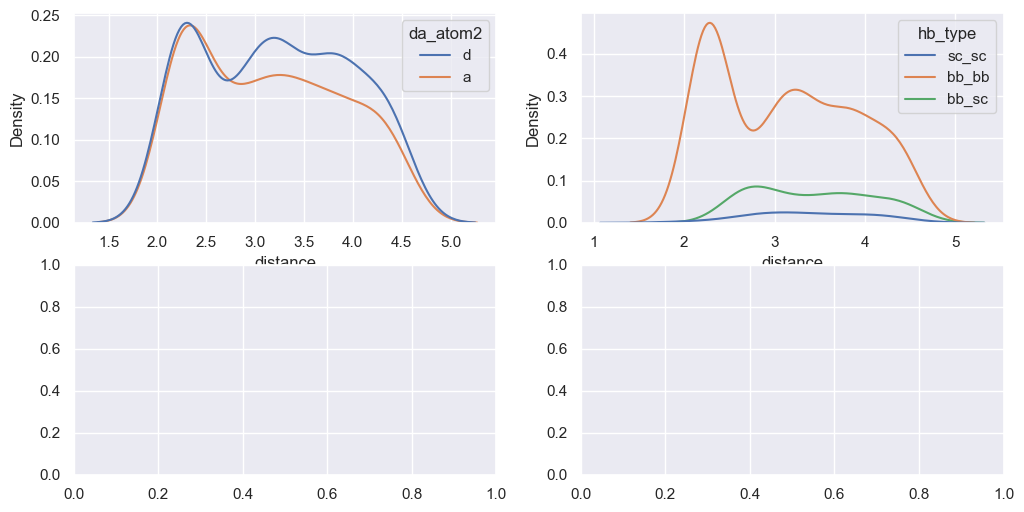

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(12,6))
plt.rcParams['font.size'] = 14
plt.rc('axes', titlesize = 14)
sns.kdeplot(data=lb_7adh, x="distance", hue="da_atom2", common_norm=True, ax=axes[0,0])
sns.kdeplot(data=lb_7adh, x="distance", hue="hb_type", common_norm=True, ax=axes[0,1])


## Function 7: get_LBHB_pairs_for_struc_list

In [103]:
def get_LBHB_pairs_for_struc_list(data_directory, struc_list):
    all_LBHB_data = []
    for struc in struc_list:
        try:
          struc_LBHB_data = get_LBHB_pairs("%s/%s/%s/%s"%(data_directory, struc[0], struc[1], struc), struc, 3.8, 16)
          struc_LBHB_data['struc']=struc
          all_LBHB_data.append(struc_LBHB_data)
        except:
            print("failed to add LBHB for %s"%(struc))
      
    all_LBHB_pairs = pd.concat(all_LBHB_data, ignore_index=True)
    return(all_LBHB_pairs)


In [ ]:
#data_directory = '../data'
#struc_list = pdb_list[22000:len(pdb_list)-2]
#allprots2 = get_LBHB_pairs_for_struc_list(data_directory, struc_list)
#allprots2.to_csv("../results/2kproteins_fullhb.csv")

In [148]:
allprots2 = pd.read_csv('../results/hb_data2.csv')
print("Original Data: ", allprots2.shape)
df_cat = pd.read_csv('../results/catalyticly_identified_sites.csv')
df_cat = df_cat[["pdb_name", "catalytic", 'Chain Length']]
df_cat = df_cat.rename(columns={"pdb_name": "struc", "catalytic": "cat", 'Chain Length': 'length'}, errors="raise")
print(allprots2.columns)
df_prots = allprots2[["atom2", "atom1", "residue2", "residue1","resNum2", "resNum1", "charge_diff",
                       'da_atom2', 'distance', 'metal_name', 'metal_dist', 'hb_type', 'struc']]
newdf = df_prots.merge(df_cat, how='left', on='struc')
print("Original Data: ", newdf.shape)

Original Data:  (6013351, 14)
Index(['Unnamed: 0', 'atom2', 'atom1', 'residue2', 'residue1', 'resNum2',
       'resNum1', 'da_atom2', 'distance', 'charge_diff', 'metal_name',
       'metal_dist', 'hb_type', 'struc'],
      dtype='object')
Original Data:  (9225554, 15)


In [146]:
#Filter for low barrier
newdf = newdf[newdf["distance"] <= 2.6]
print(newdf.shape)
newdf.head()

(2597018, 15)


,atom2,atom1,residue2,residue1,resNum2,resNum1,charge_diff,da_atom2,distance,metal_name,metal_dist,hb_type,struc,cat,length
0,O,N,THR,ALA,58,59,-0.15,a,2.207,MG,6.786,bb_bb,121p_A,False,166
1,N,O,LYS,ALA,147,146,0.15,d,2.213,MG,13.808,bb_bb,121p_A,False,166
2,N,O,GLU,ASP,31,30,0.15,d,2.215,MG,9.925,bb_bb,121p_A,False,166
3,N,O,GLY,ALA,60,59,0.15,d,2.216,MG,8.205,bb_bb,121p_A,False,166
4,N,O,ILE,LEU,24,23,0.15,d,2.220,MG,14.671,bb_bb,121p_A,False,166


/Users/m872g256/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


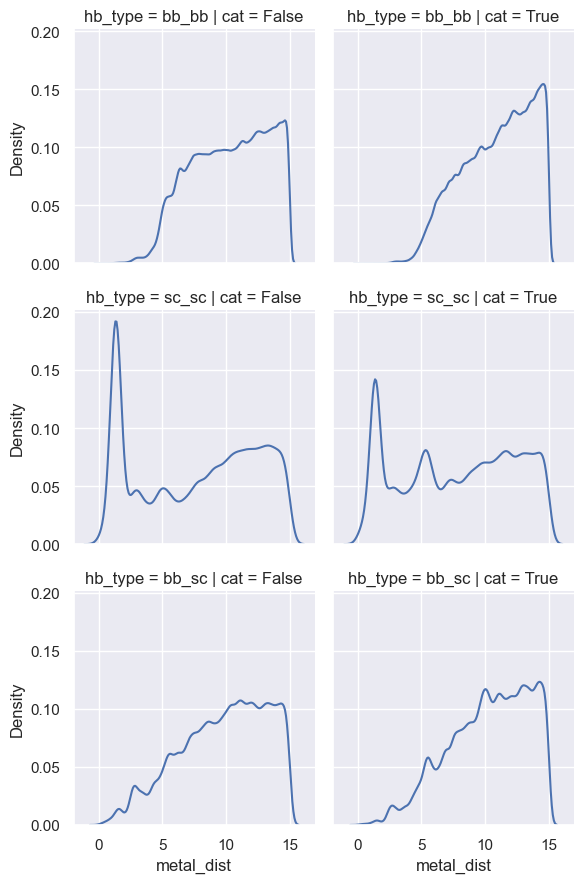

In [152]:
#Number of proteins with n hydrogen bond interactions
import pandas as pd
import seaborn as sns
import math
#dfx = (newdf.groupby(['cat', 'ind'])['length'].agg([('mean', 'mean'), ('stdv', 'std'), ('n', 'count')]).reset_index()
#    [['cat', 'ind', 'mean', 'stdv', 'n']])
#dfx['sterr'] = dfx.stdv/dfx.n
#fx.head(10)
g = sns.FacetGrid(data=newdf, col='cat', row='hb_type')
g.map(sns.kdeplot,'metal_dist')

In [137]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
def heatmapplot(df=newdf, xvar = "distance",  yvar = "metal_dist", hbtype="bb_bb", cat=True, mind=2, maxd=3.5, xlabs="", ylabs="",y1=2.4, y2=2.6): 
    sns.set(rc={'figure.figsize':(8, 5)})
    df2 = df[df['hb_type'] == hbtype]
    df2 = df2[df2['cat'] == cat]
    df2 = df2[df2['metal_dist'] <= 15]
    df2 = df2[df2['distance'].between(mind,maxd)]
    p1 = sns.jointplot(x=xvar, y=yvar, data=df2, kind='hist', cmap ="YlOrBr", legend=True, cbar=True)
    plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
    pos_joint_ax = p1.ax_joint.get_position()
    pos_marg_x_ax = p1.ax_marg_x.get_position()
    p1.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
    p1.fig.axes[-1].set_position([.83, pos_joint_ax.y0, .07, pos_joint_ax.height])
    plt.xlabel(xlabs)
    plt.ylabel(ylabs)
    plt.ylim((-0.02, 0.02)) 
    #plt.axhline(y=y1, color='k', linestyle='-.')
    #plt.axhline(y=y2, color='k', linestyle='-.')
    figname = "../img/heatmap_" + yvar[:3] + "_"+ hbtype +  "_" + str(cat)[0]+ "_" + str(mind)+ str(maxd)+".png"
    plt.savefig(figname, dpi=300) 
    plt.show()
    print(figname)
    print(df2.shape)

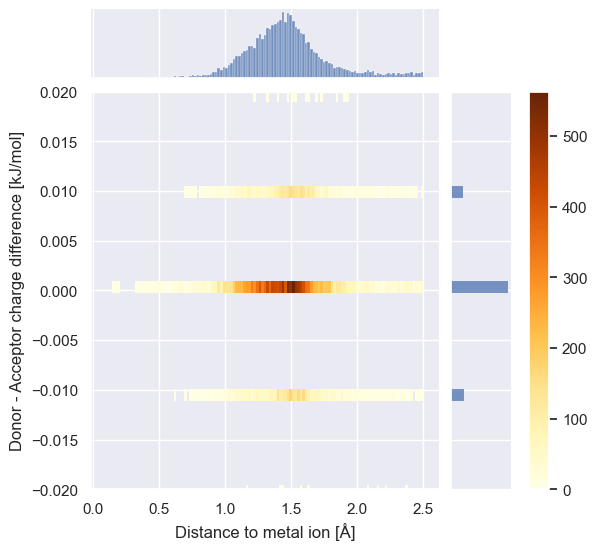

../img/heatmap_cha_sc_sc_F_23.5.png
(37489, 16)


In [139]:
plot_xlab = 'Distance to metal ion [Å]'
plot_ylab1 = 'Donor - Acceptor distance [Å]'
plot_ylab2 = 'Donor - Acceptor charge difference [kJ/mol]'
#yvar = "distance" or yvar="charge_diff"
# use y1=y2=0 if charge_diff, y1=2.4 and y2=2.6 if distance
newdf2 = newdf[newdf["metal_dist"] <= 2.5]
heatmapplot(newdf2, "metal_dist", "charge_diff", "sc_sc", False, 2, 3.5, plot_xlab, plot_ylab2, 0, 0)

Text(0.5, 0, 'Hydrogen bond lenght [Å]')

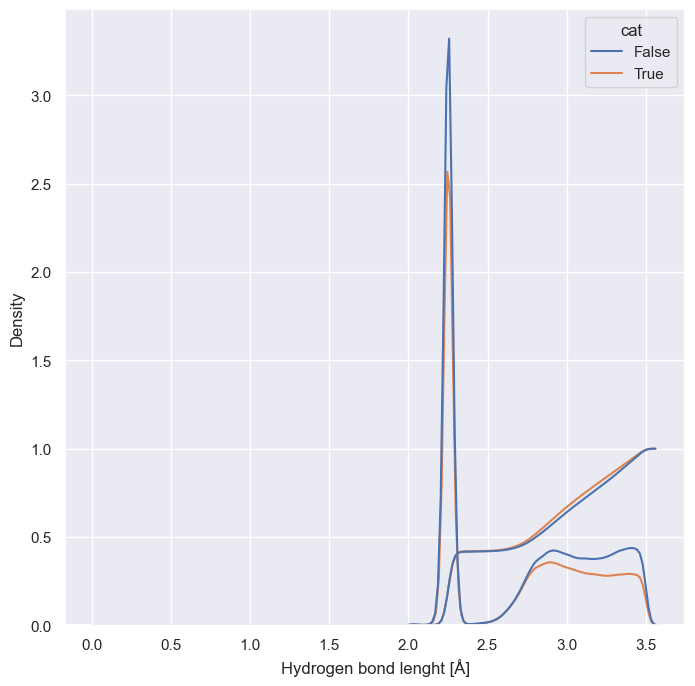

In [107]:
sns.set(rc={'figure.figsize':(8,8)})
sns.kdeplot(data=newdf, x="distance", hue='cat', legend=True)
plt.xlabel('Hydrogen bond lenght [Å]')
sns.kdeplot(data=newdf, x="distance", hue="cat",
    cumulative=True, common_norm=False, common_grid=True)
plt.xlabel('Hydrogen bond lenght [Å]')

In [279]:
import math

dfx = (df200.groupby(['hb_type'])['distance'].agg([('mean', 'mean'), ('stdv', 'std'), ('n', 'count')]).reset_index()
    [['hb_type', 'mean', 'stdv', 'n']])
dfx['sterr'] = dfx.stdv/dfx.n
dfx.head(10)

,hb_type,mean,stdv,n,sterr
0,bb_bb,2.807701,0.536980,67409,0.000008
1,bb_sc,3.119137,0.360249,9367,0.000038
2,sc_sc,3.040876,0.381211,5300,0.000072


In [158]:
import math
dfx = (newdf.groupby(['cat', 'ind'])['length'].agg([('mean', 'mean'), ('stdv', 'std'), ('n', 'count')]).reset_index()
    [['cat', 'ind', 'mean', 'stdv', 'n']])
dfx['sterr'] = dfx.stdv/dfx.n
dfx.head(10)

,cat,ind,mean,stdv,n,sterr
0,False,"(0, 1]",355.843577,245.185224,9046,0.027104
1,False,"(1, 2]",279.959055,227.041725,71803,0.003162
2,False,"(2, 3]",306.633465,222.993739,36534,0.006104
3,False,"(3, 4]",332.742269,252.232754,52745,0.004782
4,False,"(4, 5]",293.052820,219.782000,123986,0.001773
5,False,"(5, 6]",277.613629,203.679645,281455,0.000724
6,False,"(6, 7]",278.403972,194.858690,372783,0.000523
7,False,"(7, 8]",293.908735,194.975121,438797,0.000444
8,False,"(8, 9]",309.298203,200.642458,456638,0.000439
9,False,"(9, 10]",317.620255,200.075388,474661,0.000422


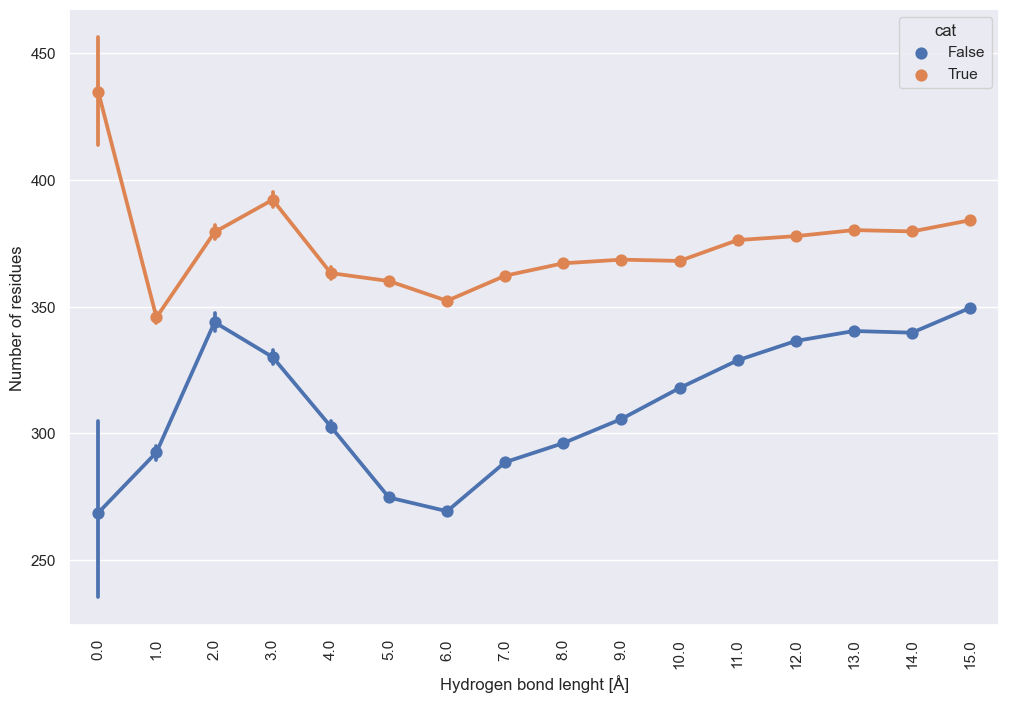

In [109]:
newdf['ind'] = newdf['metal_dist'].round(0)
sns.set(rc={'figure.figsize':(12,8)})
sns.pointplot(data=newdf, x="ind", y="length", hue="cat")
plt.xlabel('Hydrogen bond lenght [Å]')
plt.ylabel('Number of residues')
plt.xticks(rotation=90)
plt.show()

In [74]:
import requests
import re
def get_ecnumbers(pdb_id):
    path = "https://data.rcsb.org/rest/v1/core/entry/"+pdb_id
    data = requests.get(path)
    ec_descriptor = data.json()['struct']['pdbx_descriptor']
    print(ec_descriptor)
    ec_number = re.findall(r"E\.C\.(\d+\.\d+\.\d+\.\d+)", ec_descriptor)
    return([pdb_id, ec_number[0]])

In [75]:
try:
    pdb_id = input("Write yout PBD-id:")
    ec_pdb = get_ecnumbers(pdb_id)
except:
    ec_pdb = "nonEnz"
print(ec_pdb[1])

PHOSPHOLIPASE C
o


In [113]:
agg_metaldist = (newdf.groupby(['cat','struc', 'ind'])['metal_dist'].agg([('n', 'count'),('mdmean', 'mean'), ('mdstdv', 'std')]).reset_index()
    [['cat', 'struc','ind', 'n', 'mdmean', 'mdstdv']])
agg_dist = (newdf.groupby(['cat','struc', 'ind'])['distance'].agg([('n', 'count'),('dmean', 'mean'), ('dstdv', 'std')]).reset_index()
    [['cat', 'struc', 'ind', 'n', 'dmean', 'dstdv']])
print(agg_dist.shape, agg_metaldist.shape)
agg_metaldist[['dmean', 'dstdv']] = agg_dist[['dmean', 'dstdv']]
print(agg_metaldist.shape)
agg_metaldist.to_csv("../results/hb_aggregated.csv")
agg_metaldist.head(15)

(314430, 6) (314430, 6)
(314430, 8)


,cat,struc,ind,n,mdmean,mdstdv,dmean,dstdv
0,False,121p_A,2.0,2,1.910000,0.267286,3.179000,0.151321
1,False,121p_A,3.0,1,2.967000,NaN,2.262000,NaN
2,False,121p_A,4.0,1,3.552000,NaN,2.252000,NaN
3,False,121p_A,6.0,6,6.064833,0.312778,2.582667,0.509297
4,False,121p_A,7.0,5,7.134400,0.267833,2.582200,0.481874
5,False,121p_A,8.0,14,8.011714,0.322600,2.999500,0.523722
6,False,121p_A,9.0,12,9.038917,0.242124,2.744750,0.512156
7,False,121p_A,10.0,10,9.993000,0.310709,2.394100,0.243608
8,False,121p_A,11.0,8,11.000875,0.227384,2.789875,0.468428
9,False,121p_A,12.0,10,12.035600,0.270112,2.647900,0.438609


In [118]:
cat_metaldist = (newdf.groupby(['cat', 'ind'])['metal_dist'].agg([('n', 'count'),('mdmean', 'mean'), ('mdstdv', 'std')]).reset_index()
    [['cat', 'ind', 'n', 'mdmean', 'mdstdv']])
cat_dist = (newdf.groupby(['cat', 'ind'])['distance'].agg([('n', 'count'),('dmean', 'mean'), ('dstdv', 'std')]).reset_index()
    [['cat', 'ind', 'n', 'dmean', 'dstdv']])
print(cat_dist.head(3))
print(cat_metaldist.head(3))
cat_metaldist[['dmean', 'dstdv']] = agg_dist[['dmean', 'dstdv']]
print(agg_metaldist.shape)
cat_metaldist.to_csv("../results/hb_cat_aggregated.csv")
cat_metaldist.head(5)

     cat  ind      n     dmean     dstdv
0  False  0.0    101  3.312079  0.174366
1  False  1.0  25058  3.169552  0.250913
2  False  2.0  21751  3.050596  0.304571
     cat  ind      n    mdmean    mdstdv
0  False  0.0    101  0.398178  0.095298
1  False  1.0  25058  1.279073  0.176130
2  False  2.0  21751  1.798622  0.285344
(314430, 8)


,cat,ind,n,mdmean,mdstdv,dmean,dstdv
0,False,0.0,101,0.398178,0.095298,3.179000,0.151321
1,False,1.0,25058,1.279073,0.176130,2.262000,NaN
2,False,2.0,21751,1.798622,0.285344,2.252000,NaN
3,False,3.0,30503,3.010858,0.269354,2.582667,0.509297
4,False,4.0,36860,4.098509,0.279878,2.582200,0.481874


## Function 8: five_angles

Ectract the five main angles in a LBHB

In [119]:
hydrogens = {
    'LYZ_NZ':  ['1HZ', '2HZ', '3HZ'], 
    'ARG_NH1': ['1HH1', '2HH1'], 
    'ARG_NH2': ['1HH2', '2HH2'], 
    'HIS_NE2': [''],
    'HIS_ND1': ['HD1'],
    'TYR_OH': ['HH'],
    'CYS_SG': ['HG'],
    'SER_OG' : ['HG'],
    'THR_OG1' : ['HG1']
}
donor = []
for j, k in hydrogens.items():
    donor.append(j)
donor

['LYZ_NZ',
 'ARG_NH1',
 'ARG_NH2',
 'HIS_NE2',
 'HIS_ND1',
 'TYR_OH',
 'CYS_SG',
 'SER_OG',
 'THR_OG1']

In [130]:
import pandas as pd
import numpy as np
from Bio.PDB import PDBParser 
from Bio.PDB import *

#________________________________________________________________________________________________________________
# Function to extract atoms adjacent-accpetor/donor-hydrogen for single LYS, ARG, HIS, ASP, GLU, TYR, CYS
# any function starts with a for "atoms"
def alys(residue):
  ce = [atom for atom in residue.get_atoms() if atom.get_name() == "CE"]
  nz = [atom for atom in residue.get_atoms() if atom.get_name() == "NZ"]
  lysa = [ce, nz]
  return lysa

def aarg1(residue):
  cz = [atom for atom in residue.get_atoms() if atom.get_name() == "CZ"]
  nh1 = [atom for atom in residue.get_atoms() if atom.get_name() == "NH1"]
  arga = [cz, nh1]
  return arga
def aarg2(residue):
  cz = [atom for atom in residue.get_atoms() if atom.get_name() == "CZ"]
  nh2 = [atom for atom in residue.get_atoms() if atom.get_name() == "NH2"]
  arga = [cz, nh2]
  return arga

def ahis1(residue): 
  cg = [atom for atom in residue.get_atoms() if atom.get_name() == "CG"]
  nd1 = [atom for atom in residue.get_atoms() if atom.get_name() == "ND1"]
  hisa = [cg, nd1]
  return hisa
def ahis2(residue): 
  cd2 = [atom for atom in residue.get_atoms() if atom.get_name() == "CD2"]
  ne2 = [atom for atom in residue.get_atoms() if atom.get_name() == "NE2"]
  hisa = [cd2, ne2]
  return hisa

def aasp1(residue):
  cg = [atom for atom in residue.get_atoms() if atom.get_name() == "CG"]
  od1 = [atom for atom in residue.get_atoms() if atom.get_name() == "OD1"]
  aspa = [cg, od1]
  return aspa
def aasp2(residue):
  cg = [atom for atom in residue.get_atoms() if atom.get_name() == "CG"]
  od2 = [atom for atom in residue.get_atoms() if atom.get_name() == "OD2"]
  aspa = [cg, od2]
  return aspa

def aglu1(residue):
  cd = [atom for atom in residue.get_atoms() if atom.get_name() == "CD"]
  oe1 = [atom for atom in residue.get_atoms() if atom.get_name() == "OE1"]
  glua = [cd, oe1]
  return glua
def aglu2(residue):
  cd = [atom for atom in residue.get_atoms() if atom.get_name() == "CD"]
  oe2 = [atom for atom in residue.get_atoms() if atom.get_name() == "OE2"]
  glua = [cd, oe2]
  return glua

def atyr(residue):
  cz = [atom for atom in residue.get_atoms() if atom.get_name() == "CZ"]
  oh = [atom for atom in residue.get_atoms() if atom.get_name() == "OH"]
  tyra = [cz, oh]
  return tyra

def acys(residue):
  cb = [atom for atom in residue.get_atoms() if atom.get_name() == "CB"]
  sg = [atom for atom in residue.get_atoms() if atom.get_name() == "SG"]
  cysa = [cb, sg]
  return cysa

def aser(residue):
  cb = [atom for atom in residue.get_atoms() if atom.get_name() == "CB"]
  og = [atom for atom in residue.get_atoms() if atom.get_name() == "OG"]
  sera = [cb, og]
  return sera

def athr(residue):
  cb = [atom for atom in residue.get_atoms() if atom.get_name() == "CB"]
  sg = [atom for atom in residue.get_atoms() if atom.get_name() == "SG"]
  thra = [cb, sg]
  return thra

def aasn1(residue):
  cg = [atom for atom in residue.get_atoms() if atom.get_name() == "CG"]
  nd2 = [atom for atom in residue.get_atoms() if atom.get_name() == "ND2"]
  asna = [cg, nd2]
  return asna
def aasn2(residue):
  cg = [atom for atom in residue.get_atoms() if atom.get_name() == "CG"]
  od1 = [atom for atom in residue.get_atoms() if atom.get_name() == "OD1"]
  asna = [cg, od1]
  return asna

def agln1(residue):
  cd = [atom for atom in residue.get_atoms() if atom.get_name() == "CD"]
  ne2 = [atom for atom in residue.get_atoms() if atom.get_name() == "NE2"]
  glna = [cd, ne2]
  return glna
def agln2(residue):
  cd = [atom for atom in residue.get_atoms() if atom.get_name() == "CD"]
  oe1 = [atom for atom in residue.get_atoms() if atom.get_name() == "OE1"]
  glna = [cd, oe1]
  return glna

def amet(residue):
  cg = [atom for atom in residue.get_atoms() if atom.get_name() == "CG"]
  sd = [atom for atom in residue.get_atoms() if atom.get_name() == "SD"]
  meta = [cg, sd]
  return meta

def aanyN(residue):
  ca = [atom for atom in residue.get_atoms() if atom.get_name() == "CA"]
  n = [atom for atom in residue.get_atoms() if atom.get_name() == "N"]
  anyres = [ca, n]
  return anyres
def aanyO(residue):
  c = [atom for atom in residue.get_atoms() if atom.get_name() == "C"]
  o = [atom for atom in residue.get_atoms() if atom.get_name() == "O"]
  anyres = [c, o]
  return anyres
#________________________________________________________________________________________________________________
# Function to extract residues from a protein structure
def prot_residues(structure, selector):
  residues = []
  for model in structure.get_models():
    for chain in model.get_chains():
      for residue in chain.get_residues():
        res_id = residue.get_id()
        if res_id[1] in selector:
            residues.append(residue)
  return residues
#________________________________________________________________________________________________________________
# Function to extract the atoms for any HDBH residues
def res_atoms(residue):
  rname = residue.get_resname()
  res_atoms = []
  if rname=='LYS':
    res_atoms = alys(residue)
  elif rname=='ARG':
    res_atoms = aarg1(residue)
  elif rname=='HIS':
    res_atoms = ahis1(residue)
  elif rname=='ASP':
    res_atoms = aasp1(residue)
  elif rname=='GLU':
    res_atoms = aglu1(residue)
  elif rname=='SER':
    res_atoms = aser(residue)
  elif rname=='THR':
    res_atoms = athr(residue)
  elif rname=='CYS':
    res_atoms = acys(residue)
  elif rname=='ASN':
    res_atoms = aasn1(residue)
  elif rname=='GLN':
    res_atoms = agln1(residue)
  elif rname=='TYR':
    res_atoms = atyr(residue)
  elif rname=='CYS':
    res_atoms = acys(residue)
  else: 
    res_atoms = aanyN(residue)
  return res_atoms
#________________________________________________________________________________________________________________
# Function to extract the six atoms that coudl participate in the LBHB angle calculation
def lbhb_pair_atoms(pdb_file, lbhb_data):
  residues1 =  lbhb_data["resNum1"]
  residues2 =  lbhb_data["resNum2"]
  struct_id = pdb_file[-14:-10]
  p = PDBParser()
  s = p.get_structure(struct_id, pdb_file)
  res1_atoms = prot_residues(s, residues1)
  res2_atoms = prot_residues(s, residues2)
  four_atoms = []
  for i in range(len(res1_atoms)):
    res1 = res_atoms(res1_atoms[i])
    res2 = res_atoms(res2_atoms[i])
    lbhb_atoms = [res1[0], res1[1], res2[0], res2[1]]
    four_atoms.append(lbhb_atoms)
  return four_atoms
#________________________________________________________________________________________________________________
# Function to calculate the five main angles of LBHB
def single_angle(atom1, atom2, atom3):
  v1 = atom2[0].get_coord() - atom1[0].get_coord()
  v2 = atom2[0].get_coord() - atom3[0].get_coord()
  angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
  one_angle = np.degrees(angle)
  return one_angle

def two_angles(fouratoms):
  left_angle = single_angle(fouratoms[0], fouratoms[1], fouratoms[2])
  right_angle = single_angle(fouratoms[1], fouratoms[3], fouratoms[2])
  angles = [left_angle, right_angle]
  return angles
#________________________________________________________________________________________________________________
# Function to calculate five_angles for all residues in a protein 

def protein_2angles(data_dir, struc, table_lbhb):
  path2pdb = "%s/%s/%s/%s/%s_Rlx.pdb"%(data_dir, struc[0], struc[1], struc, struc)
  four_atoms = lbhb_pair_atoms(path2pdb, table_lbhb)
  lbhb_2angles = table_lbhb.copy()
  lbhb_2angles[["langle", "rangle", "structure", "group"]] = "", "", "", ""
  i = 0
  for atoms in four_atoms:
      try: 
          angles = two_angles(atoms)
          lbhb_2angles['langle'][i] = angles[0]
          lbhb_2angles['rangle'][i] = angles[1]
          lbhb_2angles['structure'][i] = struc
          lbhb_2angles['group'][i] = struc[:1]
      except:
          print('ERROR ' + str(i))
      i += 1
  return lbhb_2angles
#________________________________________________________________________________________________________________
# Function to calculate five_angles for all proteins in a directory 
def lbhb_mainangles(data_directory, struc_list):
    all_LBHB_pairs = []
    all_2angles = []
    for struc in struc_list:
        path2pdb = "%s/%s/%s/%s"%(data_directory, struc[0], struc[1], struc)
        try:
          protein_angles = protein_2angles(data_directory, struc, get_LBHB_pairs(path2pdb, struc, 4.5, 15))
          all_2angles.append(protein_angles)
        except:
          print("failed to add LBHB for %s"%(struc))

    all_LBHB_pairs = pd.concat(all_2angles, ignore_index=True)
    return(all_LBHB_pairs)

# RUN EXAMPLE

## Single protein

This example is for 7adh (ISONICOTINIMIDYLATED LIVER ALCOHOL DEHYDROGENASE)

- Atom coordinates from a protein PDB file
- pKa values for selected residues from BLUEES file
- Coordinates for selected residues forming LBHB, merge data from PDB and BLUEES

Obtain all LBHB for a single protein. The pairs pKA values and positions are reported

In [122]:
lb_7adh.head()

,atom2,atom1,x2,y2,z2,x1,y1,z1,residue2,residue1,resNum2,resNum1,da_atom2,distance,charge_diff,metal_name,metal_dist,hb_type
0,SG,SG,-9.05,23.13,28.01,-10.50,24.60,27.66,CYS,CYS,111,103,d,2.094254,0.00,ZN,2.725266,sc_sc
1,N,O,-15.40,23.55,32.39,-14.06,25.02,31.66,ARG,CYS,101,100,d,2.118820,0.15,ZN,5.559789,bb_bb
2,N,O,3.11,7.46,20.70,1.36,7.13,21.92,ASP,SER,49,48,d,2.158657,0.15,ZN,5.766979,bb_bb
3,N,O,7.67,20.47,26.01,9.46,20.54,27.22,SER,PHE,177,176,d,2.161735,0.15,ZN,9.864313,bb_bb
4,O,N,2.59,14.44,10.37,1.59,12.66,11.09,THR,PHE,145,146,a,2.164902,-0.15,ZN,12.371799,bb_bb


In [128]:
directory = '../data'
structure = '7adh_A'
lbhb_2angles = protein_2angles(directory, structure, lb_7adh)
lbhb_2angles.head(10).iloc[:,-10:]

/Users/m872g256/Library/Python/3.9/lib/python/site-packages/Bio/PDB/PDBParser.py:416: PDBConstructionWarning: PDBConstructionException: Invalid or missing occupancy at line 5594.
Exception ignored.
Some atoms or residues may be missing in the data structure.
  warnings.warn(
/Users/m872g256/Library/Python/3.9/lib/python/site-packages/Bio/PDB/PDBParser.py:416: PDBConstructionWarning: PDBConstructionException: Invalid or missing B factor at line 5594.
Exception ignored.
Some atoms or residues may be missing in the data structure.
  warnings.warn(
/Users/m872g256/Library/Python/3.9/lib/python/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'H' for Atom (name=2HD1) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/var/folders/v3/nq35dxlx2bxg58jt43fv2h4dcfpwcn/T/ipykernel_8225/1528307318.py:191: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
/var/folders/v3/nq35dxlx

ERROR 1
ERROR 42
ERROR 55
ERROR 58
ERROR 80
ERROR 81
ERROR 93
ERROR 121
ERROR 126
ERROR 130
ERROR 142
ERROR 144
ERROR 149
ERROR 177
ERROR 189
ERROR 193
ERROR 237
ERROR 254
ERROR 273
ERROR 276


/var/folders/v3/nq35dxlx2bxg58jt43fv2h4dcfpwcn/T/ipykernel_8225/1528307318.py:191: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
/var/folders/v3/nq35dxlx2bxg58jt43fv2h4dcfpwcn/T/ipykernel_8225/1528307318.py:214: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lbhb_2angles['langle'][i] = angles[0]
/var/folders/v3/nq35dxlx2bxg58jt43fv2h4dcfpwcn/T/ipykernel_8225/1528307318.py:215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lbhb_2angles['rangle'][i] = angles[1]
/var/folders/v3/nq35dxlx2bxg58jt43fv2h4dcfpwcn/T/ipykernel_8225/152830

ERROR 312
ERROR 346
ERROR 369
ERROR 372
ERROR 374
ERROR 375


/var/folders/v3/nq35dxlx2bxg58jt43fv2h4dcfpwcn/T/ipykernel_8225/1528307318.py:191: RuntimeWarning: invalid value encountered in scalar divide
  angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
/var/folders/v3/nq35dxlx2bxg58jt43fv2h4dcfpwcn/T/ipykernel_8225/1528307318.py:214: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lbhb_2angles['langle'][i] = angles[0]
/var/folders/v3/nq35dxlx2bxg58jt43fv2h4dcfpwcn/T/ipykernel_8225/1528307318.py:215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lbhb_2angles['rangle'][i] = angles[1]
/var/folders/v3/nq35dxlx2bxg58jt43fv2h4dcfpwcn/T/ipykernel_8225/152830

,da_atom2,distance,charge_diff,metal_name,metal_dist,hb_type,langle,rangle,structure,group
0,d,2.094254,0.00,ZN,2.725266,sc_sc,NaN,NaN,7adh_A,7
1,d,2.118820,0.15,ZN,5.559789,bb_bb,,,,
2,d,2.158657,0.15,ZN,5.766979,bb_bb,0.0,NaN,7adh_A,7
3,d,2.161735,0.15,ZN,9.864313,bb_bb,0.0,NaN,7adh_A,7
4,a,2.164902,-0.15,ZN,12.371799,bb_bb,0.0,NaN,7adh_A,7
5,a,2.166795,-0.15,ZN,6.971065,bb_bb,NaN,NaN,7adh_A,7
6,d,2.167810,0.15,ZN,7.799176,bb_bb,NaN,NaN,7adh_A,7
7,d,2.185887,0.15,ZN,12.254062,bb_bb,0.0,NaN,7adh_A,7
8,d,2.192464,0.15,ZN,9.372925,bb_bb,NaN,NaN,7adh_A,7
9,d,2.193171,0.15,ZN,12.287640,bb_bb,0.0,NaN,7adh_A,7


In [ ]:
import plotly.express as px
fig = px.scatter_3d(lbhb_5angles, x='distance', y='beta', z='pKa_diff',
                    color='resName2', width=1200, height=720, 
                    labels={
                     "alpha": "Angle H-N1-N2",
                     "beta": "Angle N1-H-N2",
                     "pKa_diff": "pKa Differences" } )
fig.update_traces(marker=dict(size=5))
fig.show()

## Angles for a whole directory

In [32]:
data_directory = '../data'
struc_list = pdb_list[22251:len(pdb_list)-2]
allprots2 = lbhb_mainangles(data_directory, struc_list)

failed to add LBHB for 7rxn_A
failed to add LBHB for 7tli_A
failed to add LBHB for 7tln_A
failed to add LBHB for 830c_A
failed to add LBHB for 830c_B
failed to add LBHB for 8adh_A
failed to add LBHB for 8cpa_A
failed to add LBHB for 8paz_A
failed to add LBHB for 8rxn_A
failed to add LBHB for 8tli_A
failed to add LBHB for 8tln_E
failed to add LBHB for 8xia_A
failed to add LBHB for 966c_A
failed to add LBHB for 9rub_A
failed to add LBHB for 9rub_B


ValueError: No objects to concatenate

In [140]:
allprots2['atm2'] = allprots2['atom_name2'].str[0]
allprots2[:10]

,atom_name2,resName2,seqNum2,x2,y2,z2,res_id1,atom_name1,resName1,seqNum1,x1,y1,z1,res_id2,distance,bond_id,x,y,z,close_metal_resName,close_metal_seqNum,close_metal_distance,epsilon,alpha,beta,gamma,theta,structure,group,atm2
0,N,LYS,3,-2.28,-9.02,-1.69,LYS3,O,LYS,2,-2.88,-10.54,-0.20,LYS2,2.211447,LYS2_LYS3_bb_bb,-2.580,-9.780,-0.945,FE,53,14.992189,,,,,,,,N
1,O,LYS,46,-6.41,-4.04,9.00,LYS46,N,SER,47,-7.02,-3.62,11.09,SER47,2.217341,LYS46_SER47_bb_bb,-6.715,-3.830,10.045,FE,53,9.909831,,,,,,,,O
2,O,TYR,13,0.75,-8.47,1.66,TYR13,N,ASP,14,2.62,-9.52,2.24,ASP14,2.221666,TYR13_ASP14_bb_bb,1.685,-8.995,1.950,FE,53,11.597269,,,,,,,,O
3,N,TYR,4,-1.86,-6.76,1.01,TYR4,O,LYS,3,-3.27,-6.71,-0.72,LYS3,2.232375,LYS3_TYR4_bb_bb,-2.565,-6.735,0.145,FE,53,12.393679,,,,,,,,N
4,N,THR,7,-2.07,1.42,5.93,THR7,O,CYS,6,0.02,1.46,5.11,CYS6,2.245462,CYS6_THR7_bb_bb,-1.025,1.440,5.520,FE,53,5.363164,,,,,,,,N
5,O,GLU,12,4.18,-6.29,3.04,GLU12,N,TYR,13,1.91,-6.33,3.27,TYR13,2.281973,GLU12_TYR13_bb_bb,3.045,-6.310,3.155,FE,53,8.793279,,,,,,,,O
6,O,SER,47,-8.61,-1.09,9.09,SER47,N,GLU,48,-6.46,-1.27,9.87,GLU48,2.294188,SER47_GLU48_bb_bb,-7.535,-1.180,9.480,FE,53,10.026651,,,,,,,,O
7,N,GLU,12,3.78,-3.44,3.24,GLU12,O,TYR,11,1.96,-2.56,4.33,TYR11,2.296715,TYR11_GLU12_bb_bb,2.870,-3.000,3.785,FE,53,6.282279,,,,,,,,N
8,OG1,THR,7,-4.44,2.80,6.82,THR7,O,GLU,48,-4.37,0.22,7.22,GLU48,2.611762,GLU48_THR7_bb_sc,-4.405,1.510,7.020,FE,53,7.387924,,,,,,,,O
9,O,GLU,48,-4.37,0.22,7.22,GLU48,OG1,THR,7,-4.44,2.80,6.82,THR7,2.611762,GLU48_THR7_sc_bb,-4.405,1.510,7.020,FE,53,7.387924,,,,,,,,O


In [ ]:
import math
import plotly.express as px
fig = px.scatter(allprots2, x='distance', y='close_metal_distance',
                    color='atm2', width=1200, height=720)
fig.update_traces(marker=dict(size=5))
fig.show()

In [217]:
allprots2.iloc[:, 15:].tail(3)

,bond_id,pKa_diff,x,y,z,close_metal_resName,close_metal_seqNum,close_metal_distance,epsilon,alpha,beta,gamma,theta,structure,group
843,TYR286_TYR303,0.404,39.370,4.315,26.720,MG,500,15.761517,NaN,NaN,NaN,0.0,76.331108,9rub_A,NaN
844,ARG152_ARG418,0.756,28.195,5.810,55.480,MG,500,25.772296,109.56044,78.851936,98.817535,2.330534,8.802656,9rub_A,NaN
845,LYS166_GLU194,6.641,34.195,19.075,34.915,MG,500,1.974861,28.412233,41.14801,127.943176,10.908798,29.076488,9rub_A,NaN


In [ ]:
def get_LBHB_pairs_for_struc_list(data_directory, struc_list):
    all_LBHB_data = []
    for struc in struc_list:
        try:
          struc_LBHB_data = get_LBHB_pairs("%s/%s/%s/%s"%(data_directory, struc[0], struc[1], struc), struc)
          struc_LBHB_data['struc']=struc
          all_LBHB_data.append(struc_LBHB_data)
        except:
            print("failed to add LBHB for %s"%(struc))
    all_LBHB_pairs = pd.concat(all_LBHB_data, ignore_index=True)
    return(all_LBHB_pairs)

In [ ]:
data_directory = '../data'
struc_list = pdb_list[22251:len(pdb_list)-2]
allprots = get_LBHB_pairs_for_struc_list(data_directory, struc_list)
print(len(allprots))

(31, 23)
(141, 23)
(141, 23)
(84, 23)
(83, 23)
failed to add LBHB for 8adh_A
(124, 23)
(56, 23)
(31, 23)
(141, 23)
(141, 23)
(239, 23)
(90, 23)
(228, 23)
failed to add LBHB for 9rub_B
846


In [ ]:
data_directory = '/Users/m872g256/Dropbox (Slusky Lab)/ElectricAve/ElectricAve_data'
struc_list = pdb_list
allprots = get_LBHB_pairs_for_struc_list(data_directory, struc_list)
print(len(allprots))

(102, 23)
(197, 23)
(197, 23)
(197, 23)
(197, 23)
(252, 23)
(252, 23)
(252, 23)
(252, 23)
(252, 23)
(252, 23)
(252, 23)
(252, 23)
(268, 23)
(268, 23)
(59, 23)
(59, 23)
(59, 23)
(59, 23)
(259, 23)
(101, 23)
(100, 23)
(105, 23)
(344, 23)
(344, 23)
(344, 23)
(344, 23)
(238, 23)
(235, 23)
(236, 23)
(236, 23)
(57, 23)
(132, 23)
(274, 23)
(274, 23)
(274, 23)
(274, 23)
(274, 23)
(274, 23)
(274, 23)
(274, 23)
(210, 23)
(210, 23)
(210, 23)
(210, 23)
(210, 23)
(210, 23)
(210, 23)
(210, 23)
(274, 23)
(274, 23)
(274, 23)
(274, 23)
(274, 23)
(274, 23)
(274, 23)
(274, 23)
(205, 23)
(44, 23)
(92, 23)
(92, 23)
(48, 23)
(81, 23)
(78, 23)
(78, 23)
(163, 23)
(163, 23)
(93, 23)
(93, 23)
(51, 23)
(82, 23)
(82, 23)
(82, 23)
(82, 23)
(34, 23)
(236, 23)
(236, 23)
(236, 23)
(236, 23)
(106, 23)
(40, 23)
(139, 23)
(162, 23)
(162, 23)
(162, 23)
(162, 23)
(210, 23)
(162, 23)
(162, 23)
(140, 23)
(142, 23)
(140, 23)
(142, 23)
(63, 23)
(63, 23)
(124, 23)
(193, 23)
(193, 23)
(193, 23)
(209, 23)
(209, 23)
(209, 23)
(20

In [ ]:
allprots.to_csv("../results/LBHBs_all.csv")

NameError: name 'allprots' is not defined

## Plot hydrogen bonds

- x: hydrogen bonding
- y: bonding distance from centroid
- z: density

In [ ]:
#%pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
allprots.columns

Index(['atom_name2', 'resName2', 'seqNum2', 'predicted_pKa2', 'x2', 'y2', 'z2',
       'atom_name1', 'resName1', 'seqNum1', 'predicted_pKa1', 'x1', 'y1', 'z1',
       'distance', 'bond_id', 'pKa_diff', 'x', 'y', 'z', 'close_metal_resName',
       'close_metal_seqNum', 'close_metal_distance', 'struc'],
      dtype='object')

import plotly.express as px
fig = px.scatter_3d(allprots, x='predicted_pKa1', y='predicted_pKa2', z='distance',
                    color='resName1', width=1200, height=720, 
                    labels={
                     "predicted_pKa1": "pKa1",
                     "predicted_pKa2": "pKa2",
                     "distance": "Distance (A)" } )
fig.update_traces(marker=dict(size=0.5))
fig.show()
fig.write_html("lbhb_7-9.html")

# HIDROGEN BOND ANGLES

![Waterfall](https://www.r-ccs.riken.jp/labs/cbrt/wp-content/uploads/2017/04/definition_H-bonds-768x328.png)

It is required to calculate: 

- distance of the three sides of the triangle ($d_{NO}$, $d_{HO}$ and $d_{NH}$). Use the rule of Pitagoras. 

- angles $\alpha$ and $\beta$. Use the Law of Cosines.


In [ ]:
data_directory = '../data'
struc_list = pdb_list[:len(pdb_list)-2]
all_angles = lbhb_mainangles(data_directory, struc_list)

In [234]:
all_angles.to_csv("../results/LBHB_all_angles.csv")

In [ ]:
import math
import plotly.express as px
allprots = all_angles[(all_angles["pKa_diff"] < 6) & (all_angles["distance"] < 3)]
fig = px.scatter_3d(allprots, x='distance', y='beta', z='pKa_diff',
                    color='group', width=1200, height=720, 
                    labels={
                     "alpha": "Angle H-N1-N2",
                     "beta": "Angle [N1-H-N2]",
                     "pKa_diff": "pKa Differences" } )
fig.update_traces(marker=dict(size=0.5))
fig.show()

In [78]:
def solvnrg(slvnrg_file):
     with open(slvnrg_file, 'r') as f:
          data = f.read()
     lines = data.split('\n')
     df = pd.DataFrame([line.split() for line in lines if line.startswith('SOLV')],
                    columns=['c1', 'c2', 'c3', 'atom', 'res', 'resn', 'charge', 'solv_nrg'])
     df = df.drop(columns=['c1', 'c2', 'c3'])
     df['atom_id'] = df['res'] + df['resn'] + '_' +df['atom']

     print(df.columns, "\n", df.shape)
solvnrg_path = '../data/7/a/7adh_A/7adh_A_bluues.solv_nrg'
solvnrg(solvnrg_path)

In [ ]:

solvnrg_path = '../data/7/a/7adh_A/7adh_A_bluues.solv_nrg'
solvnrg(solvnrg_path)
